## Using nestpy to plot NEST predictions and analyze data
A tutorial by Chloe Liebenthal (Rice University Astroparticle Group), November 2020

This tutorial will introduce you to the basics of plotting NEST curves, as well as some data utility functions that allow you to select datasets and compare them to the predictions made by NEST curves. These functions are also very useful in analyzing and comparing data.

### What is NEST?

NEST stands for Noble Element Simulation Technique. It is a C++ package that allows users to simulate various processes in noble elements, such as scintillation, ionization, and electroluminescence. Modelling these processes is very useful for various fields of particle physics research, such as dark matter detectors (including the XENON experiment), double beta decay searches, and radiation detection. It is particularly usefull for loe-energy nuclear recoils, such as the ones we'd expect from dark matter, so it is a very useful tool for our search!

Right now, NEST is able to model these various processes in all three phases of xenon- solid, liquid, and gas- and other noble elements, like argon, are modeled by NEST as well. Another key feature of NEST is that it allows users to change the parameters of the detector used in creating NEST's predictions. By using information about a preexisting detector or creating a custom one, users can take variables like temperature, pressure, efficiency and electric field variations into account for their predictions. 

#### How can NEST's predictions help me?

NEST's predictions are very useful as a supplement for experimental data. It can generate predictions for an experiment's results before the experiment takes place, which can be very helpful in formulating hypotheses and getting a general idea of how the experiment might turn out. Then, after it takes place, comparing the data to NEST again can indicate which data is anomalous compared to the predictions, prompting researchers to take another look at that data to see what factors may have caused the discrepancy. 

#### What is nestpy?

nestpy is a python binding for the NEST library, so it can be accessed through python instead of C++. Simply importing the nestpy module will give you complete access to NEST's simulations!

### Plotting yields with nestpy

Let's take a look at how we can use some of nestpy's simplest functions to create and plot useful predictions. In this case, we're going to look at the relationship between the recoil energy and the charge and light yields present during a nuclear recoil event.

Recoil energy refers to the energy level of the collision when an outside particle hits a xenon particle inside the detector. Charge and light yields respectively refer to the amount of electrons and photons that are released by the collision.

First, we'll need to import a few python modules. In addition to nestpy, numpy is necessary for the mathematical functions we will use to generate our nestpy predictions. matplotlib will be used to create plots of the predictions.

In [165]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt

Next, we need to start setting up the background information for the predictions we'll create. For this example, we'll load up the preexisting deector settings for XENON10. 

Then, we will define *nc*, which stands for 'NEST calculations', as the specific parameters of the calculations that NEST makes based on the XENON10 settings. This way, calling *nc* later on will tell our nestpy functions about these parameters.

In [166]:
detector = nestpy.DetectorExample_XENON10()
nc = nestpy.NESTcalc(detector)

Next, it's time to define the function that we'll use to calculate the yield predictions. These functions return an array (a format in which numpy allows us to store data) that stores various possible yield values.

@np.vectorize at the beginning is what Python calls a decorator. This means that it is a line of code that 'decorates', or expands the scope, of the functions it modifies right underneath it. In this case, it means that the output of GetYieldsVectorized will be vectorized, which means it is outputted as an array.

GetYieldsVectorized is the function that generates this array. It does this by calling the built-in nc.GetYields() function from nestpy. However, in order to generate the proper kwargs (keyword arguments) for nc.GetYields(), another set of functions is necessary; PhotonYield() and ElectronYield() each call GetYieldsVectorized() with different kwargs based on *yield_type*, generating yields for either electrons or photons.

In [167]:
@np.vectorize

def GetYieldsVectorized(yield_type, **kwargs):
    "Generates yield predictions based on recoil energy values."
    yield_object = nc.GetYields(**kwargs)
    return getattr(yield_object, yield_type)

def PhotonYield(**kwargs):
    "Calls GetYieldsVectorized() for light yields."
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
 
def ElectronYield(**kwargs):
    "Calls GetYieldsVectorized() for charge yields."
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

The next function will use the yields generated by GetYieldsVectorized() to output a tuple (a python term for a sequence of other objects) that contains NEST's predictions for recoil energy values and for the corresponding yields. These will be the x-axis and y-axis on our plot, respectively. In order to generate these predictions, the function will call the functions from the previous cell.

There are two inputs necessary for the nest_curve() function. The first is *field*, which specifies the strength of the electric field in the hypothetical detector NEST uses to make its predictions. This is measured in V/cm, or volts per centimeter. The second input is *yield_type*, which specifies whether the predictions are for electron or photon yields. *yield_type*'s possible values are 'Charge' or 'Light'.

The nest_curve() function will first create a large array with a wide range of possible recoil energy values- specifically, 1000 of them. Then, for each value in this *energies* array, the function will call the GetYieldsVectorized() function (using either ElectronYield() or PhotonYield(), depending on *yield_type* and use it to predict what the yield would be at that energy level in the given *field*. nest_curve() will then return a tuple containing the hypothetical energy values and then their corresponding yields.

In [168]:
def nest_curve(field, yield_type):
    """
    Creates x-axis and y-axis data for plotting a NEST curve of recoil energy vs. yields.
    """
    energies = np.logspace(-1, 2, 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies),1))
    kwargs = {'energy': energies, 'drift_field': field}
    if yield_type == 'Charge':
        yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies #yields/keV
    if yield_type == 'Light':
        yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (energies, yields)

Now that the functions to create NEST predictions have been written, we can put them all together into a function that uses their output to create plots.  Since it is helpful for a plot to include what versions of NEST and nestpy were used to create it, we'll begin by creating a textbox that contains this information.

Next, we'll write a function that uses matplotlib.pyplot to turn the values generated by nest_curve() into a plot. As input, the yields_plot() function will need a list of different *field* values to generate prediction for, as well as the *yield_type* (which, again, may be 'Charge' or 'Light'). There is also an option for the user to save their plot as a .png image; by default this functionality is not activated. Then, the plot itself can be created.

In [169]:
version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')

def yields_plot(fields, yield_type, savefig=False):
    '''
    Makes a plot of all the different yields at various energies and field values.
    '''
    
    #Create a plot, then define a subplot (which is where information about the yield plot will be stored).
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    
    
    #The plot needs a title, which reflects what kind of yields the plot represents.
    title = [yield_type, 'Yields for Nuclear Recoils']
    title = ' '.join(str(v) for v in title)
    subplot1.set_title(title, fontsize = 20)

    
    #Each field has a name generated for it to add to the plot's legend. Then, the nest_curve() function creates
    # a full set of predictions based on each field. All of these predictions are then plotted.
    for field in fields:
        name = [field, "V/cm"]
        name = ' '.join(str(v) for v in name)
        subplot1.plot(nest_curve(field, yield_type)[0], nest_curve(field, yield_type)[1], label=name)

    #Based on whether the yield_type is Charge or Light, the plot should be formatted somewhat differently in order to avoid
    #textboxes and legends overlapping with the prediction curves. Since charge and light yields are measured in different
    #units (charge yields are in number of electrons / kiloelectronvolts, and light yields are in 
    #number of photons / kiloelectrovolts),the two different plots need different y-axis labels.
    
    if yield_type == 'Charge':
        subtitle = [yield_type, 'Yield [n$_e$/keV]']
        plt.ylim(0, 9)
        subplot1.legend(loc='lower center', fontsize= 'large', ncol=3)
        subplot1.text(5, 3, version_textbox, bbox=bbox, horizontalalignment='right', fontsize='x-large')


    if yield_type == 'Light':
        subtitle = [yield_type, 'Yield [n$_y$/keV]']
        plt.ylim(0, 18)
        subplot1.legend(loc='upper left', fontsize= 'large', ncol=3)
        subplot1.text(1, 10, version_textbox, bbox=bbox, horizontalalignment='right', fontsize='x-large')
    subtitle = ' '.join(str(v) for v in subtitle)
    subplot1.set_ylabel(subtitle, fontsize = 15) 

    
    #The x-axis, which represents recoil energy measured in kiloelectronvolts, also needs a label. We will also set the x-axis
    #to have a log scale, so that it will depict the wide range of energy levels well.
    subplot1.set_xscale('log')
    subplot1.set_xlabel('Recoil Energy [keV]', fontsize =15)
    
    #We finish formatting the plot by setting the marging to 0, so the plot's axes will not extend further than the data in the
    #plot. This removes extra white space at the edges of the plot.
    subplot1.margins(0)
    
    #Finally, if the user chooses to save their plot, we set filenames for the .png images.
    if savefig:
        if yield_type == 'Charge':
            plt.savefig('charge_yield_plot.png')    
        if yield_type == 'Light':
            plt.savefig('light_yield_plot.png')   

Now let's test out our functions! We'll start by creating a light yield plot with just one electric field value to keep things simple.

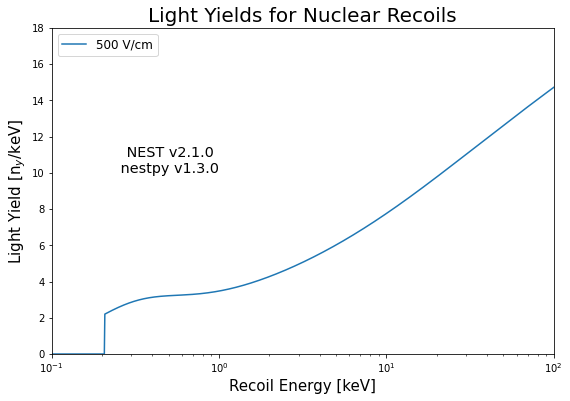

In [170]:
yields_plot([500], 'Light')

That looks great! Now let's create a similar charge yield plot.

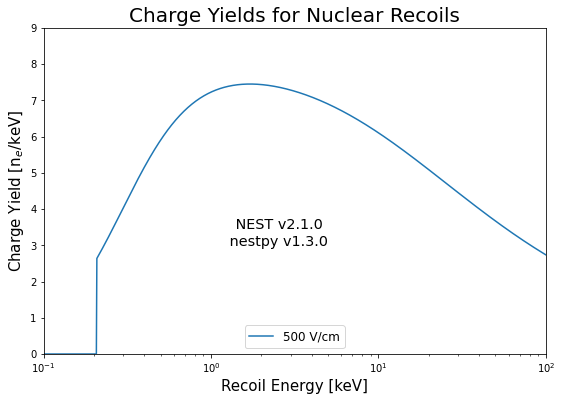

In [171]:
yields_plot([500], 'Charge')

Both of these plots look like they came out well. Let's try creating a charge yield plot and a light yield plot with a wide range of field values, so we can generate lots of predictions.

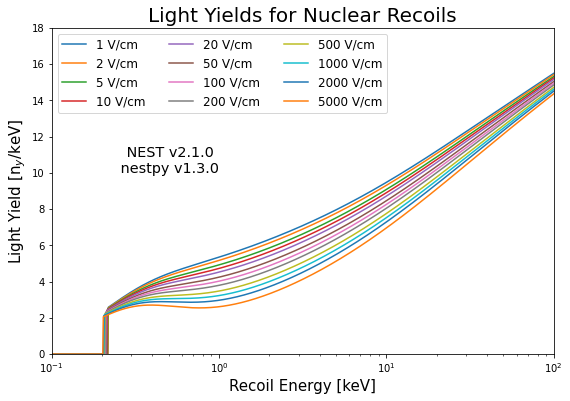

In [172]:
all_fields = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
yields_plot(all_fields, 'Light')

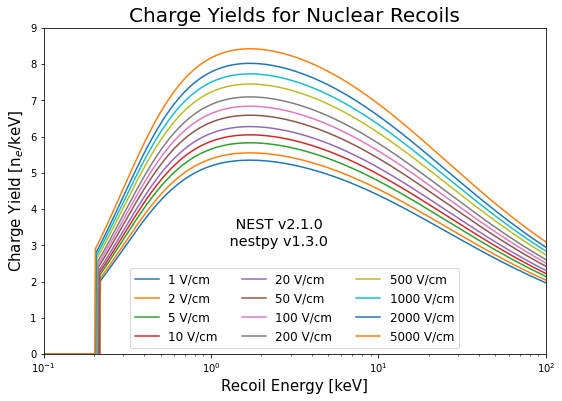

In [173]:
yields_plot(all_fields, 'Charge')

Our prediction plots look great! Now, let's move to another type of plot you can create using nestpy- a plot that compares NEST predictions to real data values. This plot will use many of the functions we wrote before, but also incorporate real experimental data.

### Data comparison plots
#### Preparing our data

First, let's import all of the modules we're going to need. The json and glob modules are included because the experimental data is stored in JSON format. pandas allows us to use dataframes, another type of data format that is similar to a spreadsheet.

In [174]:
import json
import glob
import pandas as pd

Let's open our datasets as pandas dataframes. For this tutorial, I'll use one charge yield and one light yield nuclear recoil dataset. I saved them as JSONs, but you may have them stored differently.

In [175]:
charge_df = pd.read_json('charge/columbia_270.0_qy.json')
light_df = pd.read_json('light/xenon1t_82.0_ly.json')

dataframes = [charge_df, light_df]

The get_yields() function is used to directly compare NEST predictions to real data. It is similar to the nest_curve() function, but instead of generating predictions based on a wide range of pregenerated recoil energy values, this function will take a list of energies as input and create yield predictions for each one. This is useful for one aspect of the plot, the residuals subplot, which shows how accurate NEST's predictions were.

In [176]:
def get_yields(energies, field, yield_type):
    """
    Creates y-axis data for plotting a NEST curve at specific recoil energy values.
    """

    kwargs = {'energy': energies, 'drift_field': field}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (nest_yields)

Now that we've written another NEST helper function, we can create another function using matplotlib.pyplot that generates a plot of our dataset and the NEST prediction curve, and a residuals subplot comparing NEST's prediction to the real data to see how accurate the predictions are.

In [195]:
def data_comparison(df):
    '''
    Makes a scatter plot of experimental data vs. NEST's predictions.
    ''' 
    #We create a plot with two subplots- one for the main plot and one for the residuals. The subplots are set
    #up to share an x-axis and to have the main plot 3 times taller than the residuals.
    fig, (subplot1, subplot2) = plt.subplots(2, figsize=(7,5), sharex = True, gridspec_kw={'height_ratios': [3, 1]})
     
    #To create the experimental data on the plot, we need to pull the data out of the dataframes we created earlier.
    #The dataframe also contains other useful information, such as the field strength, yield type, and the name
    #of the experiment whose data we are using.
    data_yields = df['yield'].tolist()
    energy = df['corrected_energy'].tolist()
    driftField = df['field'].iloc[0]
    yieldType = df['yield_type'].iloc[0] 
    name = df['identification'].iloc[0]
    
    #The plot needs a title.
    title = [yieldType.capitalize(), "Yields vs. NEST's Predictions"]
    title = ' '.join(str(v) for v in title)
    subplot1.set_title(title, fontsize = 20)
    
    #Since not all datasets contain error information, we only store error data if it exists, then we flag 
    #whether or not errors are included.
    error_flag = False
    if 'recoil_error' in list(df.columns):
        error_flag = True
        error = df['recoil_error'].tolist()
        
    #Here we create the main scatterplot of the experimental data, including some formatting such as color and
    #a name label for the legend.
    subplot1.scatter(energy, data_yields, s=15, c= '#1f77b4',label= name)
    
    #If error information is included, we add y-errorbars to the scatter plot.
    if error_flag == True:
        subplot1.errorbar(energy, data_yields, yerr = df['recoil_error'].tolist(), linewidth = 1, fmt = 'none')
    else:
        pass
        
    #Now we use the nest_curve() function to create a curve at the same field value as the experimental data.
    #We plot it in the same way that we did in our last plot example.
    nest_label = ['NEST: ', driftField, ' V/cm']
    nest_label = ''.join(str(v) for v in nest_label)
    curve = nest_curve(driftField, yieldType.capitalize())
    subplot1.plot(curve[0], curve[1], 'c--', label= nest_label)
    
    #We'll also limit the range of the plot to a range of data values fairly close to those of the data, which
    #makes the plot more readable.
    max_x, min_x, max_y, min_y = max(energy), min(energy), max(data_yields), min(data_yields)
    subplot1.set_xlim([min_x - 5, max_x + 5])
    subplot1.set_ylim([min_y - .5, max_y + .5])
    
    #Add labels and a legend.
    subplot1.legend(loc='upper left') 
    subplot1.legend(prop={'size': 9})
    subplot1.set_xlabel('Recoil Energy [keV]')
    if yieldType == 'charge':
        subplot1.set_ylabel('Charge Yield [e-/keVr]') 
    else:
        subplot1.set_ylabel('Light Yield [ph/keVr]')   
   
    #Now we'll create a subpplot with residuals. This is a statistical method that compares the 
    #accuracy of a measured value and its corresponding prediction.
    nest_yvals = get_yields(energy, driftField, yieldType)
    if error_flag == True:
        resid_vals = [(x - y)/z for x, y, z in zip(data_yields, nest_yvals, error)]
    else:
        resid_vals = [x - y for x, y in zip(data_yields, nest_yvals)]
    residuals = dict(zip(energy, resid_vals))
    
    subplot2.scatter(list(residuals.keys()), list(residuals.values()))
    
    #Labels for the residuals subplot. We also place a horizontal line at 0 to indicate the 
    #minimum amount of deviation from the prediction.
    subplot2.axhline(y=0, ls= '--')
    subplot2.set_ylabel('\u03C3 (deviation)')
    
    #If the residual value is sufficiently high, the subplot will change to a log scale on the
    #y-axis to improve readability.
    if any(abs(x) > 10 for x in residuals.values()):
        subplot2.set_yscale('symlog')
    
    #Adding grid lines also makes the plot more readable.
    subplot1.grid(b=True)
    subplot2.grid(b=True)
    
    #tight_layout() improves formatting.
    plt.tight_layout()

Now it's time to plot our datasets!

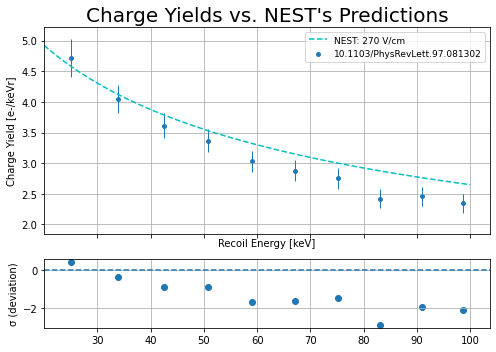

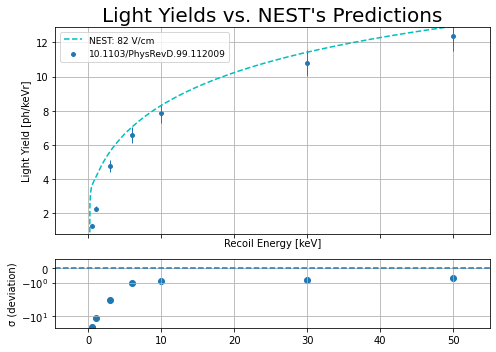

In [196]:
data_comparison(charge_df)
data_comparison(light_df)

I'm curious about how NEST's prediction accuracy changes with field strength, so I'll use the functions I've written to find out. First, I'll load all of the datasets. The plots wil have field strength on the x-axis and percent error on the y-axis.

The glob module makes it easy to load lots of files at once. This function, load_all(), will quickly convert all the data stored as JSONs in to pandas dataframes.

In [216]:
def load_all(pathname):
    '''
    This creates a list of dataframes from JSONs.
    ''' 
    files = glob.glob(pathname)
    #Input the pathname as wherever you have your JSONs stored.
    dfs = []
    for file in files:
        df = pd.read_json(file)
        dfs.append(df)
    return dfs

In [217]:
charge_dfs = load_all('charge/*.json')
light_dfs = load_all('light/*.json')

The get_yield_diffs() function will read each dataframe, generate NEST's predictions for its recoil energy values and field strength, and then calculate the percent error. Then the plotdiffs() function uses get_yield_diffs to generate plots of the percent error vs. the field strength.

In [218]:
def get_yield_diffs(dfs):
    """
    Finds the percent error between a data point and the NEST prediction at the corresponding
    recoil energy value. Takes a list of dataframes as input.
    """
    yield_diffs = []
    for df in dfs:
        driftField = df['field'].iloc[0]
        yields = df['yield'].tolist()
        energy = df['corrected_energy'].tolist()
        yieldType = df['yield_type'].iloc[0]
        try:
            error = df['recoil_error'].tolist()
        except:
            pass
    
        nest_predictions = get_yields(energy, driftField, yieldType)   
        x = [] 
        
        #This block of code performs a percent error calculation on 
        #the experimental data and NEST's predictions.
        for i in range(len(yields)):
            try:
                x.append([abs((yields[i] - nest_predictions[i])/nest_predictions[i]) * 100, error[i]])
            except:
                x.append([yields[i] - nest_predictions[i]])
        yield_diffs.append(x)  
        
    return (yield_diffs)

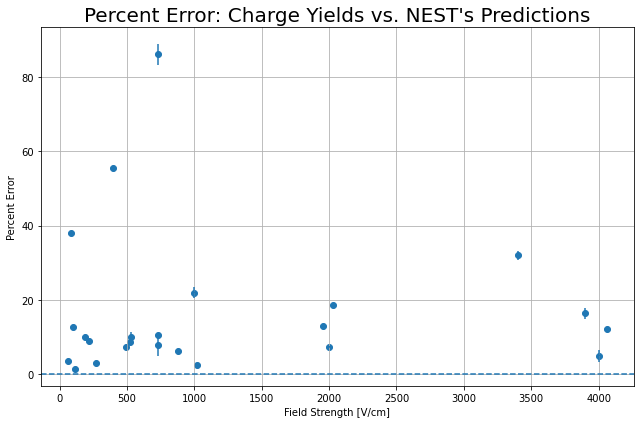

In [219]:
def plotdiffs(dfs):
    """
    Plots percent error, as evaluated by get_yield_diffs(). Takes a list of dataframes as input.
    Make sure that all the dataframes you input are the same yield type.
    """
    yield_diffs = get_yield_diffs(dfs)
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    
    yieldType = dfs[0]['yield_type'].iloc[0]

    title = ["Percent Error:", yieldType.capitalize(), "Yields vs. NEST's Predictions"]
    title = ' '.join(str(v) for v in title)
    subplot1.set_title(title, fontsize = 20)
    
    fields = []
    for df in dfs:
        fields.append(df['field'].iloc[0])   
    yvals = list(yield_diffs[i][0][0] for i in range(len(yield_diffs)))

    subplot1.scatter(fields, yvals)
    plt.errorbar(fields, yvals, yerr=list(yield_diffs[i][0][1] for i in range(len(yield_diffs))), fmt=',')
    subplot1.axhline(y=0, ls= '--')
    subplot1.set_ylabel('Percent Error')
    subplot1.set_xlabel('Field Strength [V/cm]')
    
    subplot1.grid(b=True)
    plt.tight_layout()
    
plotdiffs(charge_dfs)

Now I'll do the same thing for light yields.

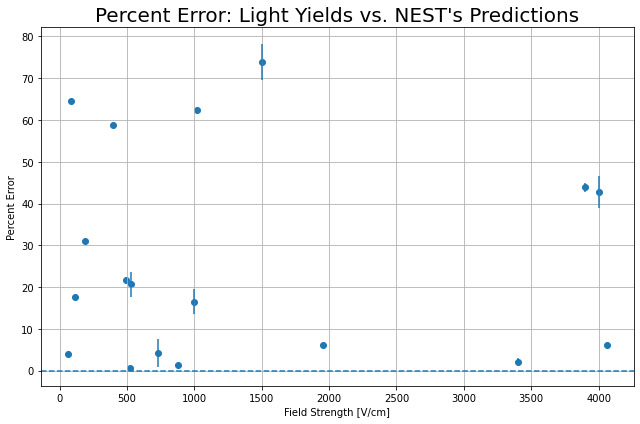

In [210]:
plotdiffs(light_dfs)

With these plots complete, we can visualize NEST's general accuracy in predicting yield over a range of different field strengths. Notably, the percent error tends to be lower in the 500-1000 V/cm range. This is because there are more experiments that use field strengths in this range, thus providing more data to calibrate NEST with.

### Next Steps with NEST

Now that you've learned about the basic functionality of NEST, I hope you'll continue to explore its many utilities and create your own plots based on the data and predictions relevant to your research. If you would like to learn more about NEST, I would recommend visiting the collaboration's website, where you can find NEST publications, benchmark plots, citation information, and other information as well.